In [76]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle as pkl
from scipy import stats

import csv
import sys
import pandas as pd
import os

verbose = True

Nickdir = '/home/kmason/fullosc/NicksCode/1L1PSelection/1e1pBDT/'

finalPred = False
fset = 0 #looking at fsets 1 and 2

    
cutmodedir = {0:'FinalSelection',1:'KinCut',2:'HighE',3:'LowBDT'}[cutMode]

lowEpatch = False
vtxCut    = 5

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17

if fset==1: 
    DAT_POT1  = 1.935765e20
    DAT_POT2 = 0
    DAT_POT3  = 2.99974063e20
elif fset==2: 
    DAT_POT1 = 4.0129213616e20
    DAT_POT2 = 0
    DAT_POT3 = 3.85169302616e20

    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


print(DAT_POT1,DAT_POT2,DAT_POT3)
print(DAT_POT1+DAT_POT2+DAT_POT3)

def poisson_errors(k, CL = 0.6827):
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    print("Poisson errors:",k)
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


1.935765e+20 0 2.99974063e+20
4.93550563e+20


In [77]:
tag='23Aug2021_vA_fullLowE_withPi0Sample_newShowerCalib'
#tag='7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu'

filetaglist = {1:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0','fullosc'],
               2:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','fullosc'],
               3:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0','fullosc']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,2,r)
        else:
            pstring = psavedir+'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        try:
            df[r][filetag] = pd.read_parquet(pstring)
            print(len(df[r][filetag]))
        except:
            print('No Events')
            pass
        



 #################### RUN 1 #################### 

Sample: data
2125
Sample: ext
No Events
Sample: overlay
No Events
Sample: intrinsics
No Events
Sample: ncpi0
No Events
Sample: ccpi0
No Events
Sample: fullosc
No Events


 #################### RUN 2 #################### 

Sample: data
No Events
Sample: ext
No Events
Sample: overlay
No Events
Sample: intrinsics
No Events
Sample: fullosc
No Events


 #################### RUN 3 #################### 

Sample: data
2364
Sample: ext
No Events
Sample: overlay
No Events
Sample: intrinsics
No Events
Sample: ncpi0
No Events
Sample: ccpi0
No Events
Sample: fullosc
No Events


In [78]:
# set up all of the plots to do for the best fit oscillation
varb_names = ['Enu_1e1p']

var_labels = [r'$E_\nu^{Range}$ [MeV]']

ranges = [ (200,2400)]

varlabel_dict = {name:label for name,label in zip(varb_names,var_labels)}
range_dict = {name:rnge for name,rnge in zip(varb_names,ranges)}

range_dict['sigprob'] = (0.95,1.0)
    

In [79]:
# defining some helper functions
#  MakeBDTcut(dfc,cut,bdtmode,nBDTs)

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    
    for col in idf.columns:
        print(col)
  
    for b in range(nBDTs):
        sp = idf[b'sigprob%i'%b]
        tvw = idf[b'tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=[b'run',b'subrun',b'event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=[b'run',b'subrun',b'event'],inplace=True)
    

    

In [80]:
mu_cutoff = 0.46149198646840239

def chi2_cnp(M,mu):
    c2c=0
    if mu>0:
        if M != 0:
            c2c = (M - mu)**2/(3 / (2 / mu + 1 / M))
        else:
            c2c = mu/2#(M - mu)**2/(3 / (2 / mu + 1 / mu))
    return c2c

def chi2_pois(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = 2*(mu - M + M*np.log(M/mu))
        else:
            c2c = 2*mu
    return c2c

def chi2_pears(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = (M-mu)**2 / mu
        else:
            c2c = 2*mu
    return c2c

def chi2_thresh(M,mu,mode='cnp'):
    c2c=0
    if mu > mu_cutoff and mode=='cnp':
        c2c = chi2_cnp(M,mu)
    elif mu > mu_cutoff and mode=='pearson':
        c2c = chi2_pears(M,mu)
    else:
        c2c = chi2_pois(M,mu)
    return c2c

def cov_pois(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (M-mu)**2 / (2*(mu - M + M*np.log(M/mu)))
        else:
            cov = mu/2
    return cov

def cov_cnp(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (3 / (2 / mu + 1 / M))
        else:
            cov = mu/2
    return cov

def cov_pears(M,mu):
    cov=0
    if mu > 0:
        cov = mu
    return cov

def cov_thresh(M,mu,mode='cnp'):
    cov=0
    if mu>mu_cutoff and mode=='cnp':
        cov=cov_cnp(M,mu)
    elif mu>mu_cutoff and mode=='pearson':
        cov=cov_pears(M,mu)
    else:
        cov=cov_pois(M,mu)
    return cov

# function to get the normalization uncertainty
def getnormalizationunc(det_sys_m,rwt_sys_m,p):
    msys = det_sys_m+rwt_sys_m
    f_unc = (sum(sum(msys)))/(sum(p)**2)
    print("func",f_unc,(sum(p)),(sum(sum(msys))))
    return f_unc

0
b'run'
b'subrun'
b'event'
b'vtxid'
b'Enu_1e1p'
b'Eta'
b'PT_1e1p'
b'AlphaT_1e1p'
b'SphB_1e1p'
b'PzEnu_1e1p'
b'ChargeNearTrunk'
b'Q0_1e1p'
b'Q3_1e1p'
b'Thetas'
b'Phis'
b'PTRat_1e1p'
b'Proton_ThetaReco'
b'Proton_PhiReco'
b'MinShrFrac'
b'MaxShrFrac'
b'BjXB_1e1p'
b'BjYB_1e1p'
b'Proton_Edep'
b'Electron_Edep'
b'Lepton_ThetaReco'
b'Lepton_PhiReco'
b'OpenAng'
b'Xreco'
b'Yreco'
b'Zreco'
b'MPIDY_muon'
b'MPIDY_proton'
b'MPIDY_eminus'
b'shower_fraction'
b'Shower_Consistency'
b'EnuQE_lepton'
b'EnuQE_proton'
b'EnuTrue'
b'ccnc'
b'scedr'
b'POTweight'
b'GenieWeight'
b'LEEweight'
b'label'
b'newpi0flag'
b'datarun'
b'filetag'
b'cutLevel'
b'nBDTs'
b'tvweight0'
b'sigprob0'
b'tvweight1'
b'sigprob1'
b'tvweight2'
b'sigprob2'
b'tvweight3'
b'sigprob3'
b'tvweight4'
b'sigprob4'
b'tvweight5'
b'sigprob5'
b'tvweight6'
b'sigprob6'
b'tvweight7'
b'sigprob7'
b'tvweight8'
b'sigprob8'
b'tvweight9'
b'sigprob9'
b'tvweight10'
b'sigprob10'
b'tvweight11'
b'sigprob11'
b'tvweight12'
b'sigprob12'
b'tvweight13'
b'sigprob13'
b'tvwe

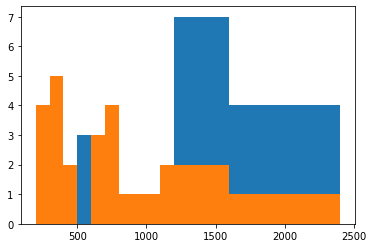

In [81]:
fudge_bkg = 1.0
fudge_sig = 1.0

plot_thresh = 0.05

# Near sideband stuff
nsbmode = 0 # 1 = Enu>500, 2 = 500<Enu<700, 3 = 0.7 < BDT < 0.95, 4 = 0.01 < BDT < 0.95
nsbrwtovr = None

#Binary Settings
sys     = False
usedata = True
plotPurity = False
topplot = False
pi0wplot = False
davioplot = False
makeCutData = True
shapeonly=False
#BDT Settings
bdtmode = 'avgscore'
nBDTs = 20
bdtpower = 0
bdtcutRange = [range_dict['sigprob'][0]]


runs_to_plot = [[1,2,3]]

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}

if cutMode in [2,3] or fset==12: 
    POTdict[1]['data'] = DATA_POT_TOT
    POTdict[2]['data'] = DATA_POT_TOT
    POTdict[3]['data'] = DATA_POT_TOT
    
pvalsa = []
pvalsf = []

cls  = ['deeppink','purple','blue','cyan','darkgreen','greenyellow','gold','brown','gray','fuchsia']

# set to best oscilation parameters
# m41=bestm
# sin41=bests
m41=0
sin41=0
um4 =0
ue4 =0
print(ue4)

for varName in varb_names:
    # only looking at Enu for now - need to get systematics for the rest still
    if varName not in ['Enu_1e1p']: continue
    if varName=='EnuTrue' and not finalPred: continue

    xlab = varlabel_dict[varName]

    bins  = [200,300,400,500,600,700,800,900,1000,1100,1200,1600,2400]
    numbins = len(bins)-1
    low   = (range_dict[varName])[0]
    high  = (range_dict[varName])[1]
    if nsbmode==2 and varName!='Enu_1e1p': numbins/=2


    for runs_included in runs_to_plot: # [run 1, run 2 run 3]

        pRatDict = {}
        pErrDict = {}

        for cut in bdtcutRange:

            if cutMode in [0,2] and varName=='sigprob': low = cut

            plotTitle = 'Final Selection | Runs:'
            plotFileName = varName
            FullPOT = 0
            POT1 = 0
            POT23 = 0

            vars_arr = []
            weights_arr = []
            labels_arr = []
            leew_arr = []
            Enu_arr = []

            dflist = []
            dfdat = pd.DataFrame()
            dflee = pd.DataFrame()
            dftot = pd.DataFrame()

            bkginttype = {}
            onvbkginttype = {}
            offvbkginttype = {}

            for r in runs_included:
                plotTitle += ' %i'%r
                plotFileName += '_%i'%r
                FullPOT += POTdict[r]['overlay']
                if r == 1: POT1 += POTdict[r]['overlay']
                elif r in [2,3]: POT23 += POTdict[r]['overlay']
                
                #loop to make cuts and set event weights
                for filetag in df[r].keys():
                    if not lowEpatch and 'lowE' in filetag: continue
                    if filetag!='data': continue
                    dfc = df[r][filetag].copy()
                    MakeBDTcut(dfc,cut,bdtmode,nBDTs)


                    vars_arr = list(dfc[b'Enu_1e1p'])
                    weights = dfc[b'Enu_1e1p']/dfc[b'Enu_1e1p']
                    if cutMode in [0,2]: weights*= dfc['bdtweight'] * dfc['sigprob']**bdtpower
                    weights*=dfc['sigprob']>range_dict['sigprob'][0]
                    weights*=dfc['sigprob']<range_dict['sigprob'][1]
                    print(len(vars_arr),len(weights))
                    d = plt.hist(vars_arr,weights=weights,bins=bins,range=(low,high),density=0)
                    
                    print("here!",d[0])
 
                    
# 

In [ ]:
# # plot cov matrices

det_sys_m = np.loadtxt(Nickdir+'CovMatrices/DetVar/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/7September2021/covMatrix/avgscore/BDTcut0.95/detsys_Enu_1e1p_run13_cutMode0_cov_smooth.csv',delimiter=',')
rwt_sys_m = np.loadtxt(Nickdir+'CovMatrices/RwghtSys/frac_covar_rewgt_highE.txt') 

fig = plt.figure(figsize=(10, 8))
plt.imshow(rwt_sys_m)
plt.gca().invert_yaxis()
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_alpha(0)
ax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.title('Fractional Systematic Covariance Matrix')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 8))
plt.imshow(det_sys_m)
plt.gca().invert_yaxis()
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_alpha(0)
ax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.title('Fractional Detector Covariance Matrix')
plt.show()
plt.close()

In [ ]:
# y = [oscbins[i]/nooscbins[i] for i in range(bins)]
# y2 = [highoscbins[i]/nooscbins[i] for i in range(bins)]
# print(y)
# x = xbins
# plt.scatter(x,y,color='blue',label='sin^2 =.01')
# plt.scatter(x,y2,color='green',label='sin^2 =.05')
# plt.axhline(y=1.0,ls='--',color='red')
# plt.title('with oscillation/ no oscillation')
# plt.legend()
# plt.show()

In [ ]:
tsavedir = 'TextFiles/'+tag+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
for bdtmode in ['avgscore','fracweight','medianscore']:
    tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'+bdtmode+'/'
    try: os.mkdir(tsavedir)
    except OSError as error: print(error)
    for r in [1,2,3]:
        for filetag in df[r].keys():
            if not lowEpatch and 'lowE' in filetag: continue
            #if not 'data' in filetag: continue
            dfc = df[r][filetag].copy()
            SaveTextFile(dfc,r,filetag+'_fset%i'%fset,0.95,bdtmode,tsavedir)

In [30]:
tsavedir = 'TextFiles/'
for bdtmode in ['avgscore']:
    for r in [3]:
        for filetag in df[r].keys():
            if not lowEpatch and 'lowE' in filetag: continue
            #if not 'data' in filetag: continue
            dfc = df[r][filetag].copy()
            SaveTextFile(dfc,r,filetag+'_fset%i'%fset,0.95,bdtmode,tsavedir)